# Bloembergen-Purcell-Pound (BPP) function

This example shows how to use `lmfit_global.py` to fit multi-dataset with Bloembergen-Purcell-Pound (BPP) function with multiple relaxation processes. 

This is an example to results published in `[Figure 4 (a)]` [Phys. Rev. B 111, 014444 (2025)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.111.014444) 

In [1]:
try:
    from lmfit_global import LmfitGlobal
except (ImportError, ModuleNotFoundError):
    import sys
    sys.path.append('../lmfit_global')
    from lmfit_global import LmfitGlobal
    
import matplotlib.pyplot as plt

load raw data...

(53, 3)

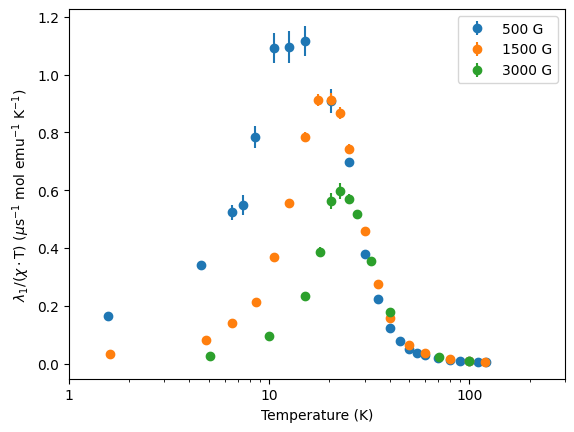

In [2]:
import os
import numpy as np
dpath = './data'  # data path

# --- Load data (skip header) ---
file='TbSQ_chiT_muSRrelaxations_LF500G_LF1500G_LF3000G.dat' # data
file=os.path.join(
    dpath,
    file
)

data = np.loadtxt(file, delimiter=',', skiprows=1)

# """ LF-muSR relaxation rates $\lambda_1$ @ LG 500, 1500, 3000 Gauss
# Columns are define as:
# 0: temp
# 1: 500G_lambda
# 2: 500G_lambda_err
# 3: 1500G_lambda
# 4: 1500G_lambda_err
# 5: 3000G_lambda
# 6: 3000G_lambda_err
# """

# --- Let extract x, y_1, y_2, y_3 and err_1, err_2, err_3 seperately

xdat = data[:, 0]

xdat

cols = [0, 1, 3, 5]
data_xy_ = data[:, cols]
cols = [2, 4, 6]
data_xy_err_ = data[:, cols]

# --- We are interesting for 1500G and 3000G data only in this case
cols = [0, 3, 5]
xy = data[:, cols]

cols = [4, 6]
xy_err = data[:, cols]


# plot raw data
plt.figure()
plt.xscale('log')
plt.xlim([1, 300])
plt.xlabel('Temperature (K)')
plt.ylabel(r'$\lambda_1/(\chi \cdot \mathrm{T})\ (\mu \mathrm{s}^{-1}\ \mathrm{mol \ emu}^{-1} \ \mathrm{K}^{-1})$')
field_lst = [500, 1500, 3000]  # in Gausss
# plt.plot(x, )
for i in range(1, data_xy_.shape[1]):
    # plt.plot(xdat, data_xy_[:, i], 'o')    
    plt.errorbar(xdat, data_xy_[:, i],  yerr=data_xy_err_[:, i-1], fmt='o', label=f'{field_lst[i-1]} G') 

plt.legend()


from matplotlib.ticker import ScalarFormatter
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

xy.shape 

built the functions... 

In [3]:
import os
import numpy as np
log2 = np.log(2)
s2pi = np.sqrt(2*np.pi)
s2 = np.sqrt(2.0)
# tiny had been numpy.finfo(numpy.float64).eps ~=2.2e16.
# here, we explicitly set it to 1.e-15 == numpy.finfo(numpy.float64).resolution
tiny = 1.0e-15

def not_zero(value):
    """Return value with a minimal absolute size of tiny, preserving the sign.

    This is a helper function to prevent ZeroDivisionError's.

    Parameters
    ----------
    value : scalar
        Value to be ensured not to be zero.

    Returns
    -------
    scalar
        Value ensured not to be zero.

    """
    return float(np.copysign(max(tiny, abs(value)), value))


def arrhenius(x, tau=1.0, sigma=1.0):
    """Calculate the Arrhenius function.

    arrhenius(x, tau, sigma) = tau * np.exp(sigma/x)
    
    Args:
        x (np.array): Temperature in Kelvin.
        tau (float): Infinite correlation time in units of sec
        sigma (float): Activation energy in units of Kelvin.

    Returns:
        array-like
    """
    sigma = max(tiny, sigma)  # units = [T], temperature 
    return tau * np.exp(sigma/x) # Arrhenius law, units = [sec]

def powerlaw(x, tau=1.0, exponent=1.0):
    """Return the powerlaw function.

    powerlaw(x, tau, exponent) = tau*x**(-exponent)

    Args:
        x (np.array): Temperature in Kelvin.
        tau (float): Infinite correlation time in units of sec
        exponent (float): Dimensionless exponent parameter.

    Returns:
        array-like
    """
    return tau*np.power(x, -1.0*exponent)


def slbpp_arrhenius(x, amplitude=1.0, tau=1.0, sigma=1.0, omega=1.0):
    """Return a simple "standard" Lorentzian BPP law lineshape with correlation function 
    that follows Arrhenius law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e. In Arrhenius law, a pre-exponential factor for tau_c =  tau*exp(sigma/x).
        sigma (float): Activation energy in units of Kelvin.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    sigma = max(tiny, sigma)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = arrhenius(x, tau, sigma) # Arrhenius law, units = [sec]
    omega_tau_c = omega * tau_c # units = [1/sec] * [sec] = [1]
    omega_tau_c_sq = omega_tau_c*omega_tau_c # units = [1]
    denom = 1.0 + omega_tau_c_sq  # units = [1]
    jw =  tau_c / denom # units = [sec] / [1] = [sec] 
    # amplitude*jw # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude*jw 


def slbpp_powerlaw(x, amplitude=1.0, tau=1.0, exponent=1.0, omega=1.0):
    """Return a simple "standard" Lorentzian BPP law lineshape with correlation function 
    that follows Power law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e In Power law, a pre-exponential factor for tau_c =  tau*x**(-exponent).
        exponent (float): dimensionless exponent parameter.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    # sigma = max(tiny, sigma)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = powerlaw(x, tau, exponent) # Power law, units = [sec]
    omega_tau_c = omega * tau_c # units = [1/sec] * [sec] = [1]
    omega_tau_c_sq = omega_tau_c*omega_tau_c # units = [1]
    denom = 1.0 + omega_tau_c_sq  # units = [1]
    jw =  tau_c / denom # units = [sec] / [1] = [sec] 
    # amplitude*jw # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude*jw 


def rlbpp_arrhenius(x, amplitude=1.0, tau=1.0, sigma=1.0, delta=1.0, omega=1.0):
    """Return refined "rectangular" BPP law lineshape with correlation function 
    that follows Arrhenius law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e. In Arrhenius law, a pre-exponential factor for tau_c =  tau*exp(sigma/x).
        sigma (float): Activation energy in units of Kelvin.
        delta (float): Width of rectangular distribution in units of Kelvin.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    # if isinstance(x, (int, float)):
    #     x = max(tiny, x)
    # else:
    #     x[where(x <= tiny)] = tiny
    #
    sigma = max(tiny, sigma)  # units = [T], temperature 
    delta = max(tiny, delta)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = arrhenius(x, tau, sigma) # Arrhenius law, units = [sec]
    b = np.exp(delta/x) # units = [1]
    arg1 = np.arctan(b * omega * tau_c) # units = [1] * [1/sec] * [sec] = [1]
    arg2 = np.arctan(omega * tau_c / b) # units =  [1/sec] * [sec] / [1] = [1]
    r = (0.5*x)/max(tiny, (omega*delta)) # units = [T] / [ [1/sec] * [T]] = [sec]
    # scale = 1.0 * r # units = [sec]
    # amplitude * r * (arg1 - arg2) # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude * r * (arg1 - arg2)


def rlbpp_powerlaw(x, amplitude=1.0, tau=1.0, exponent=1.0, delta=1.0, omega=1.0):
    """Return refined "rectangular" BPP law lineshape with correlation function 
    that follows Power law.
    
    Args:
        x (np.array): Temperature in Kelvin.
        amplitude (float): Rescaling constant in units of sec^-2.
        tau (float): Infinite correlation time in units of sec that typically follows Arrhenius law.
            i.e In Power law, a pre-exponential factor for tau_c =  tau*x**(-exponent).
        exponent (float): dimensionless exponent parameter.
        delta (float): Width of rectangular distribution in units of Kelvin.
        omega (float): Larmor frequency i.e product gamma * field units of rad/sec.

    Returns:
        array-like
    """
    # if isinstance(x, (int, float)):
    #     x = max(tiny, x)
    # else:
    #     x[where(x <= tiny)] = tiny
    #
    sigma = max(tiny, sigma)  # units = [T], temperature 
    delta = max(tiny, delta)  # units = [T], temperature 
    omega = max(tiny, omega)  # units = [1/sec]
    tau_c = powerlaw(x, tau, exponent) # Power law, units = [sec]
    b = np.exp(delta/x) # units = [1]
    arg1 = np.arctan(b * omega * tau_c) # units = [1] * [1/sec] * [sec] = [1]
    arg2 = np.arctan(omega * tau_c / b) # units =  [1/sec] * [sec] / [1] = [1]
    r = (0.5*x)/max(tiny, (omega*delta)) # units = [T] / [ [1/sec] * [T]] = [sec]
    # scale = 1.0 * r # units = [sec]
    # amplitude * r * (arg1 - arg2) # units = [1/sec]  * [1/sec]  * [sec] = [1/sec]  
    return amplitude * r * (arg1 - arg2)



# x=np.linspace(1, 300, 1000)
# GAMMA_MU_IN_MHZ_PER_GAUSS = 0.0135538817   # MHz/Gauss
# GAMMA_MU_UNITS_PER_SEC_PER_GAUSS = 0.0135538817*1e6   # 1/(seconds*Gauss)
# # y=orbach_func(x, 1.0e8, 1e-10, 335)

# field=1500 # field in Gauss

# y=slbpp_arrhenius(
#     x,
#     amplitude=1e8,
#     tau=1e-10,
#     sigma=300,
#     omega=GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*field
# )
# y=slbpp_powerlaw(
#     x,
#     amplitude=1e8,
#     tau=1e-4,
#     exponent=3.5,
#     omega=GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*field
# )

# plt.figure()
# plt.xscale('log')
# plt.plot(x,y, label='sl bpp arrh')

# f'{GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*field:.8e}'

one relaxation mechanism: **Raman or Raman-like**

built `data` and `function` **`item`** `dict` for `LmfitGlobal`  and fit...

In [4]:
# data dict
data_dict = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }


func_lst = [
    {
        'func_name': slbpp_powerlaw,
        'init_params' : {
            'amplitude': {'value':2.0055e+08, 'vary':True, 'min':0, 'max':+np.inf},
            'tau': {'value':4.0e-4, 'vary':True, 'min':1.0e-8, 'max':1.0e-2},
            'exponent': {'value':3.5, 'vary':True, 'min':3.5-0.5, 'max':3.5+0.5},
            'omega': {'value':2e7, 'vary':False},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
]

# function dict
function_dict = {
    'theory': func_lst,
    'theory_connectors': None,  
}


# items 
items = {
    'data': data_dict,              # 1. data (see above)
    'functions': function_dict,     # 2. thoery (see above)
}

In [5]:
LFG = LmfitGlobal(items, nan_policy='omit')

INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: ##############################################################
INFO: # y(x;) = slbpp_powerlaw(x, amplitude, tau, exponent, omega) #
INFO: ##############################################################


INFO: Updating parameter "omega_0"...
INFO: Updating parameter "omega_1"...
INFO: The parameter "amplitude_0" is shared with ALL "amplitude_*" parameters...
INFO: The parameter "exponent_0" is shared with ALL "exponent_*" parameters...
INFO: The parameter "tau_0" is shared with ALL "tau_*" parameters...


Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
amplitude_0  2.006e+08        0      inf     None     True     None     None
amplitude_1  2.006e+08        0      inf     None    False amplitude_0     None
exponent_0        3.5        3        4     None     True     None     None
exponent_1        3.5        3        4     None    False exponent_0     None
omega_0      1.277e+08        0      inf     None    False     None     None
omega_1      2.555e+08        0      inf     None    False     None     None
tau_0          0.0004    1e-08     0.01     None     True     None     None
tau_1          0.0004    1e-08     0.01     None    False    tau_0     None


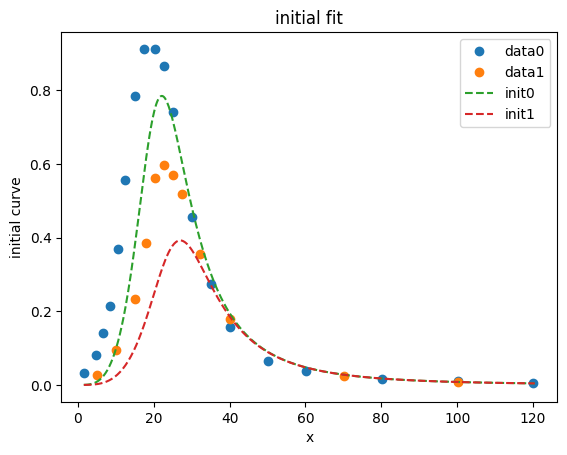

In [6]:
# --- Update omega for 1500 G and 3000 G data ---
GAMMA_MU_UNITS_PER_SEC_PER_GAUSS = 0.0135538817*1e6   # 1/(seconds*Gauss)
# for 1500 G, ωL = γμ BL
value  = 2.0*np.pi*GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*1500   # Hz or s^-1
omega_0 = ('omega_0', value, False, 0, np.inf, None, None)
LFG.update_params(omega_0)
# for 3000 G, ωL = γμ BL
value  = 2.0*np.pi*GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*3000   # Hz or s^-1
omega_1 = ('omega_1', value, False, 0, np.inf, None, None)
LFG.update_params(omega_1)

# --- set global/shared params ---
LFG.set_global('amplitude_0')
LFG.set_global('exponent_0')
LFG.set_global('tau_0')

LFG.initial_params.pretty_print()  # pretty print initial parameters

# numpoints=500 to make dense x-array, default None
axes0 = LFG.plot_init(numpoints=500)  # plot init parameters

INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name            Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: amplitude_0  2.588e+08        0      inf 5.934e+06     True     None     None
INFO: amplitude_1  2.588e+08        0      inf 5.934e+06    False amplitude_0     None
INFO: exponent_0       3.02        3        4   0.1031     True     None     None
INFO: exponent_1       3.02        3        4   0.1031    False exponent_0     None
INFO: omega_0      1.277e+08        0      inf        0    False     None     None
INFO: omega_1      2.555e+08        0      inf        0    False     None     None
INFO: tau_0        5.399e-05    1e-08     0.01 1.665e-05     True     None     None
INFO: tau_1        5.399e-05    1e-08     0.01 1.665e-05    False    tau_0     None
INFO: Coefficient of determination: R² = 0.96864429 (uniform average)...
INFO: Coefficient of determination: R² = 0.97945254 (variance-weighted)...


[[Model]]
    Model(slbpp_powerlaw)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 63
    # data points      = 31
    # variables        = 3
    chi-square         = 0.05517526
    reduced chi-square = 0.00197055
    Akaike info crit   = -190.268060
    Bayesian info crit = -185.966098
    R-squared (mean)   = 0.96864429
    R-squared (weight) = 0.97945254
[[Variables]]
    amplitude_0:  2.5882e+08 +/- 5934263.52 (2.29%) (init = 2.0055e+08)
    tau_0:        5.3995e-05 +/- 1.6646e-05 (30.83%) (init = 0.0004)
    exponent_0:   3.02033061 +/- 0.10311127 (3.41%) (init = 3.5)
    omega_0:      1.277423e+08 (fixed)
    amplitude_1:  2.5882e+08 +/- 5934263.53 (2.29%) == 'amplitude_0'
    tau_1:        5.3995e-05 +/- 1.6646e-05 (30.83%) == 'tau_0'
    exponent_1:   3.02033061 +/- 0.10311127 (3.41%) == 'exponent_0'
    omega_1:      2.554847e+08 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau_0, exponent_0)       = +0.9940
    C(amplitude_

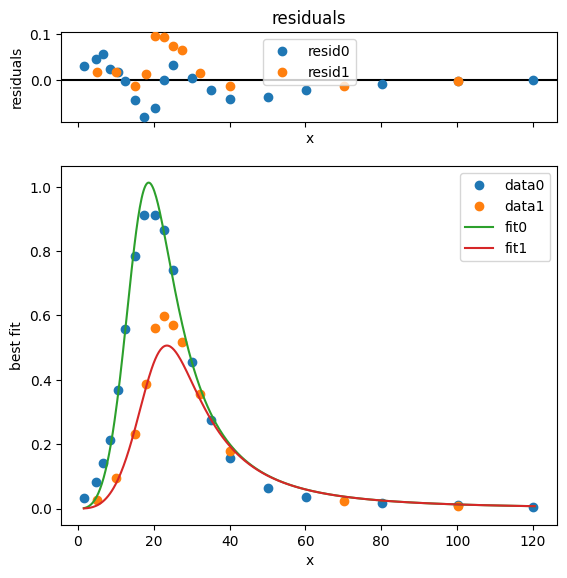

In [7]:
LFG.fit(verbose=True)  # verbose, if True will show fit parameters

# plot fit data & residuals and show initial plot (if True), 
# numpoints=500 to make dense x-array, default None
axes1 = LFG.plot(show_init=False, numpoints=500)  

LFG.report()  # report fit parameters and other attributes

two relaxation process: **Raman or Raman-like** and **Orbach**

built `data` and `function` **`item`** `dict` for `LmfitGlobal`  and fit...

In [8]:
# data dict
data_dict = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }


func_lst = [
    {
        'func_name': slbpp_powerlaw,
        'init_params' : {
            'amplitude': {'value':2.0055e+08, 'vary':True, 'min':0, 'max':+np.inf},
            'tau': {'value':3.0e-4, 'vary':True, 'min':1.0e-9, 'max':1.0e-3},
            'exponent': {'value':3.5, 'vary':True, 'min':3.5-0.5, 'max':3.5+0.5},
            'omega': {'value':2e7, 'vary':False},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    {
        'func_name': slbpp_arrhenius,
        'init_params' : {
            'amplitude': {'value':3.00e+07, 'vary':False, 'min':2.5e7, 'max':3.5e7},
            'tau': {'value':3.5e-13, 'vary':True, 'min':1.0e-13, 'max':1.0e-3},
            'sigma': {'value':330, 'vary':True, 'min':330-50, 'max':330+50},
            'omega': {'value':2e7, 'vary':False},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
]

# function dict
function_dict = {
    'theory': func_lst,
    'theory_connectors': ['+'],  
}


# items 
items = {
    'data': data_dict,              # 1. data (see above)
    'functions': function_dict,     # 2. thoery (see above)
}

3.00e+07-0.5e7

25000000.0

In [9]:
LFG = LmfitGlobal(items, nan_policy='omit')

INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: ################################################################
INFO: # y(x;) = slbpp_powerlaw(x, amplitude, tau, exponent, omega) + #
INFO: # slbpp_arrhenius(x, amplitude, tau, sigma, omega)             #
INFO: ################################################################


INFO: Updating parameter "c0_omega_0"...
INFO: Updating parameter "c1_omega_0"...
INFO: Updating parameter "c0_omega_1"...
INFO: Updating parameter "c1_omega_1"...
INFO: The parameter "c0_amplitude_0" is shared with ALL "c0_amplitude_*" parameters...
INFO: The parameter "c0_exponent_0" is shared with ALL "c0_exponent_*" parameters...
INFO: The parameter "c0_tau_0" is shared with ALL "c0_tau_*" parameters...
INFO: The parameter "c1_amplitude_0" is shared with ALL "c1_amplitude_*" parameters...
INFO: The parameter "c1_sigma_0" is shared with ALL "c1_sigma_*" parameters...
INFO: The parameter "c1_tau_0" is shared with ALL "c1_tau_*" parameters...


Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0  2.006e+08        0      inf     None     True     None     None
c0_amplitude_1  2.006e+08        0      inf     None    False c0_amplitude_0     None
c0_exponent_0        3.5        3        4     None     True     None     None
c0_exponent_1        3.5        3        4     None    False c0_exponent_0     None
c0_omega_0      1.277e+08        0      inf     None    False     None     None
c0_omega_1      2.555e+08        0      inf     None    False     None     None
c0_tau_0          0.0003    1e-09    0.001     None     True     None     None
c0_tau_1          0.0003    1e-09    0.001     None    False c0_tau_0     None
c1_amplitude_0     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_amplitude_1     3e+07  2.5e+07  3.5e+07     None    False c1_amplitude_0     None
c1_omega_0      1.277e+08        0      inf     None    False     None     None
c1_omega_1      2.555e+08   

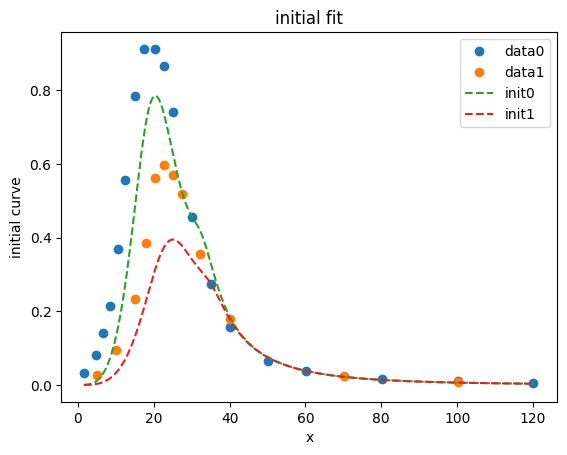

In [10]:
# --- Update omega for 1500 G and 3000 G data ---
GAMMA_MU_UNITS_PER_SEC_PER_GAUSS = 0.0135538817*1e6   # 1/(seconds*Gauss)
# for 1500 G, ωL = γμ BL
value  = 2.0*np.pi*GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*1500   # Hz or s^-1
omega_0 = ('c0_omega_0', value, False, 0, np.inf, None, None)
LFG.update_params(omega_0)
omega_0 = ('c1_omega_0', value, False, 0, np.inf, None, None)
LFG.update_params(omega_0)
# for 3000 G, ωL = γμ BL
value  = 2.0*np.pi*GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*3000   # Hz or s^-1
omega_1 = ('c0_omega_1', value, False, 0, np.inf, None, None)
LFG.update_params(omega_1)
omega_1 = ('c1_omega_1', value, False, 0, np.inf, None, None)
LFG.update_params(omega_1)
# --- I CAN DO MUCH BETTER IN THE CODE ON HOW TO HANDLE ABOVE --- WORKING PROGRESS

# --- set global/shared params ---
LFG.set_global('c0_amplitude_0')
LFG.set_global('c0_exponent_0')
LFG.set_global('c0_tau_0')
#
LFG.set_global('c1_amplitude_0')
LFG.set_global('c1_sigma_0')
LFG.set_global('c1_tau_0')


LFG.initial_params.pretty_print()  # pretty print initial parameters

# numpoints=500 to make dense x-array, default None
axes0 = LFG.plot_init(numpoints=500)  # plot init parameters

INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: c0_amplitude_0  2.498e+08        0      inf 6.219e+06     True     None     None
INFO: c0_amplitude_1  2.498e+08        0      inf 6.219e+06    False c0_amplitude_0     None
INFO: c0_exponent_0      3.042        3        4   0.1067     True     None     None
INFO: c0_exponent_1      3.042        3        4   0.1067    False c0_exponent_0     None
INFO: c0_omega_0      1.277e+08        0      inf        0    False     None     None
INFO: c0_omega_1      2.555e+08        0      inf        0    False     None     None
INFO: c0_tau_0        5.375e-05    1e-09    0.001 1.71e-05     True     None     None
INFO: c0_tau_1        5.375e-05    1e-09    0.001 1.71e-05    False c0_tau_0     None
INFO: c1_amplitude_0     3e+07  2.5e+07  3.5e+07        0    False     None     None
INFO: c1_amplitude_1     3e+07  2.5e+07  3.5e+07        0    False c1_amplitud

[[Model]]
    (Model(slbpp_powerlaw, prefix='c0_') + Model(slbpp_arrhenius, prefix='c1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 280
    # data points      = 31
    # variables        = 5
    chi-square         = 0.03955066
    reduced chi-square = 0.00152118
    Akaike info crit   = -196.588962
    Bayesian info crit = -189.419026
    R-squared (mean)   = 0.97604454
    R-squared (weight) = 0.98527120
[[Variables]]
    c0_amplitude_0:  2.4984e+08 +/- 6218794.94 (2.49%) (init = 2.0055e+08)
    c0_tau_0:        5.3746e-05 +/- 1.7097e-05 (31.81%) (init = 0.0003)
    c0_exponent_0:   3.04199917 +/- 0.10672185 (3.51%) (init = 3.5)
    c0_omega_0:      1.277423e+08 (fixed)
    c1_amplitude_0:  3e+07 (fixed)
    c1_tau_0:        1.0011e-13 +/- 1.4368e-14 (14.35%) (init = 3.5e-13)
    c1_sigma_0:      280.032425 +/- 28.5917078 (10.21%) (init = 330)
    c1_omega_0:      1.277423e+08 (fixed)
    c0_amplitude_1:  2.4984e+08 +/- 6218794.94 (2.49%) == 'c0_amp

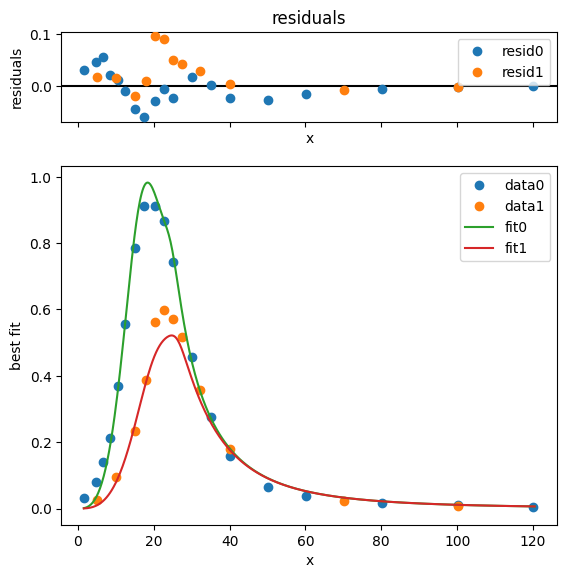

In [11]:
LFG.fit(verbose=True)  # verbose, if True will show fit parameters

# plot fit data & residuals and show initial plot (if True), 
# numpoints=500 to make dense x-array, default None
axes1 = LFG.plot(show_init=False, numpoints=500)  

LFG.report()  # report fit parameters and other attributes

three relaxation process: **Raman or Raman-like** and **Orbach** and **Direct**

built `data` and `function` **`item`** `dict` for `LmfitGlobal`  and fit...

In [12]:
# data dict
data_dict = {
    'xy': xy,         # data_xy, i.e numpy.column_stack([x, y_0, y_1, ..., y_n])
    'xrange': None    # x range in (min, max) of the data range to fit, default is None
    }


func_lst = [
    {
        'func_name': slbpp_powerlaw,
        'init_params' : {
            'amplitude': {'value':2.0055e+08, 'vary':True, 'min':0, 'max':+np.inf},
            'tau': {'value':3.0e-4, 'vary':True, 'min':1.0e-9, 'max':1.0e-3},
            'exponent': {'value':3.5, 'vary':True, 'min':3.5-0.5, 'max':3.5+0.5},
            'omega': {'value':2e7, 'vary':False},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    {
        'func_name': slbpp_arrhenius,
        'init_params' : {
            'amplitude': {'value':3.00e+07, 'vary':False, 'min':2.5e7, 'max':3.5e7},
            'tau': {'value':3.5e-13, 'vary':True, 'min':1.0e-13, 'max':1.0e-3},
            'sigma': {'value':330, 'vary':True, 'min':330-50, 'max':330+50},
            'omega': {'value':2e7, 'vary':False},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
    {
        'func_name': slbpp_powerlaw,
        'init_params' : {
            'amplitude': {'value':2.63e+07, 'vary':True, 'min':0, 'max':+np.inf},
            'tau': {'value':0.02141197, 'vary':False, 'min':0.02141197-0.01178750, 'max':0.02141197+0.01178750}, # value 0.02141197 +/- 0.01178750 (fixed)
            'exponent': {'value':11.0, 'vary':True, 'min':11.0-3, 'max':11.0+3},
            'omega': {'value':2e7, 'vary':False},
        },
        'func_kws': {}   # <-- Additional keyword arguments to pass to model function `'func_name'`.
    },
]

# function dict
function_dict = {
    'theory': func_lst,
    'theory_connectors': ['+', '+'],  
}


# items 
items = {
    'data': data_dict,              # 1. data (see above)
    'functions': function_dict,     # 2. thoery (see above)
}

3.00e+07-0.5e7

25000000.0

In [13]:
LFG = LmfitGlobal(items, nan_policy='omit')

INFO: Validating data...
INFO: Validating functions...
INFO: Validating nan policy...
INFO: Creating lmfit.Models for the functions...
INFO: Initializing lmfit.Parameters for the functions...
INFO: Setting lmfit fitting/minimization protocols for the functions...
INFO: ########################################################################
INFO: # y(x;) = slbpp_powerlaw(x, amplitude, tau, exponent, omega) +         #
INFO: # slbpp_arrhenius(x, amplitude, tau, sigma, omega) + slbpp_powerlaw(x, #
INFO: # amplitude, tau, exponent, omega)                                     #
INFO: ########################################################################


INFO: Updating parameter "c0_omega_0"...
INFO: ALL parameters ['c0_omega_0', 'c1_omega_0', 'c2_omega_0'] are now globalized with master "c0_omega_0"...
INFO: Updating parameter "c0_omega_1"...
INFO: ALL parameters ['c0_omega_1', 'c1_omega_1', 'c2_omega_1'] are now globalized with master "c0_omega_1"...
INFO: The parameter "c0_amplitude_0" is shared with ALL "c0_amplitude_*" parameters...
INFO: The parameter "c0_exponent_0" is shared with ALL "c0_exponent_*" parameters...
INFO: The parameter "c0_tau_0" is shared with ALL "c0_tau_*" parameters...
INFO: The parameter "c1_amplitude_0" is shared with ALL "c1_amplitude_*" parameters...
INFO: The parameter "c1_sigma_0" is shared with ALL "c1_sigma_*" parameters...
INFO: The parameter "c1_tau_0" is shared with ALL "c1_tau_*" parameters...
INFO: The parameter "c2_amplitude_0" is shared with ALL "c2_amplitude_*" parameters...
INFO: The parameter "c2_exponent_0" is shared with ALL "c2_exponent_*" parameters...
INFO: The parameter "c2_tau_0" is sh

Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
c0_amplitude_0  2.006e+08        0      inf     None     True     None     None
c0_amplitude_1  2.006e+08        0      inf     None    False c0_amplitude_0     None
c0_exponent_0        3.5        3        4     None     True     None     None
c0_exponent_1        3.5        3        4     None    False c0_exponent_0     None
c0_omega_0      1.277e+08        0      inf     None    False     None     None
c0_omega_1      2.555e+08        0      inf     None    False     None     None
c0_tau_0          0.0003    1e-09    0.001     None     True     None     None
c0_tau_1          0.0003    1e-09    0.001     None    False c0_tau_0     None
c1_amplitude_0     3e+07  2.5e+07  3.5e+07     None    False     None     None
c1_amplitude_1     3e+07  2.5e+07  3.5e+07     None    False c1_amplitude_0     None
c1_omega_0      1.277e+08     -inf      inf     None    False c0_omega_0     None
c1_omega_1      2.555e+08 

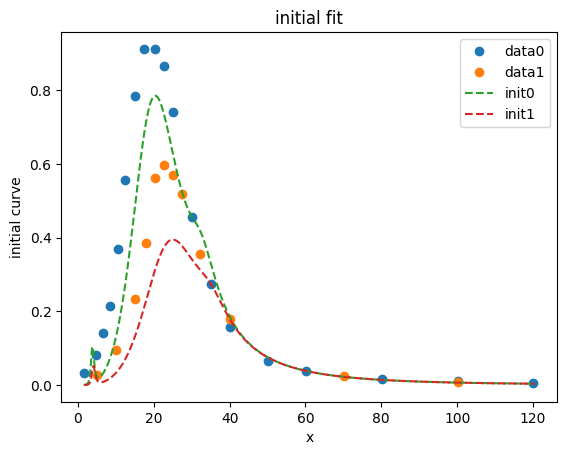

In [14]:
# --- Update omega for 1500 G and 3000 G data ---
GAMMA_MU_UNITS_PER_SEC_PER_GAUSS = 0.0135538817*1e6   # 1/(seconds*Gauss)
# for 1500 G, ωL = γμ BL
value  = 2.0*np.pi*GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*1500   # Hz or s^-1
omega_0 = ('c0_omega_0', value, False, 0, np.inf, None, None)
LFG.update_params(omega_0)

# omega_0 = ('c1_omega_0', value, False, 0, np.inf, None, None)
# LFG.update_params(omega_0)
# omega_0 = ('c2_omega_0', value, False, 0, np.inf, None, None)
# LFG.update_params(omega_0)

# MUCH BETTER AS: THEN DOING INDIVIDUALLY ABOVE, DO AS YOU LIKE
LFG.set_global_group(['c0_omega_0', 'c1_omega_0', 'c2_omega_0'])

#
# for 3000 G, ωL = γμ BL
value  = 2.0*np.pi*GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*3000   # Hz or s^-1
omega_1 = ('c0_omega_1', value, False, 0, np.inf, None, None)
LFG.update_params(omega_1)

# omega_1 = ('c1_omega_1', value, False, 0, np.inf, None, None)
# LFG.update_params(omega_1)
# omega_1 = ('c2_omega_1', value, False, 0, np.inf, None, None)
# LFG.update_params(omega_1)

# MUCH BETTER AS: THEN DOING INDIVIDUALLY ABOVE, DO AS YOU LIKE
LFG.set_global_group(['c0_omega_1', 'c1_omega_1', 'c2_omega_1'])

# --- set global/shared params ---
LFG.set_global('c0_amplitude_0')  # or use LFG.set_global_group(['c0_amplitude_0', 'c0_amplitude_1'])
LFG.set_global('c0_exponent_0')
LFG.set_global('c0_tau_0')
#
LFG.set_global('c1_amplitude_0')
LFG.set_global('c1_sigma_0')
LFG.set_global('c1_tau_0')
#
LFG.set_global('c2_amplitude_0')
LFG.set_global('c2_exponent_0')
LFG.set_global('c2_tau_0')


LFG.initial_params.pretty_print()  # pretty print initial parameters

# numpoints=500 to make dense x-array, default None
axes0 = LFG.plot_init(numpoints=500)  # plot init parameters

INFO: Fitting .....

INFO: Fitting DONE...
INFO: Parameters fit values:
INFO: Name               Value      Min      Max   Stderr     Vary     Expr Brute_Step
INFO: c0_amplitude_0  2.505e+08        0      inf 6.139e+06     True     None     None
INFO: c0_amplitude_1  2.505e+08        0      inf 6.139e+06    False c0_amplitude_0     None
INFO: c0_exponent_0      3.069        3        4   0.1081     True     None     None
INFO: c0_exponent_1      3.069        3        4   0.1081    False c0_exponent_0     None
INFO: c0_omega_0      1.277e+08        0      inf        0    False     None     None
INFO: c0_omega_1      2.555e+08        0      inf        0    False     None     None
INFO: c0_tau_0        5.868e-05    1e-09    0.001 1.899e-05     True     None     None
INFO: c0_tau_1        5.868e-05    1e-09    0.001 1.899e-05    False c0_tau_0     None
INFO: c1_amplitude_0     3e+07  2.5e+07  3.5e+07        0    False     None     None
INFO: c1_amplitude_1     3e+07  2.5e+07  3.5e+07        0    False c1_amplit

[[Model]]
    ((Model(slbpp_powerlaw, prefix='c0_') + Model(slbpp_arrhenius, prefix='c1_')) +
     Model(slbpp_powerlaw, prefix='c2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2388
    # data points      = 31
    # variables        = 7
    chi-square         = 0.03362983
    reduced chi-square = 0.00140124
    Akaike info crit   = -197.616198
    Bayesian info crit = -187.578288
    R-squared (mean)   = 0.97778216
    R-squared (weight) = 0.98747613
[[Variables]]
    c0_amplitude_0:  2.5045e+08 +/- 6138594.75 (2.45%) (init = 2.0055e+08)
    c0_tau_0:        5.8677e-05 +/- 1.8994e-05 (32.37%) (init = 0.0003)
    c0_exponent_0:   3.06948515 +/- 0.10814968 (3.52%) (init = 3.5)
    c0_omega_0:      1.277423e+08 (fixed)
    c1_amplitude_0:  3e+07 (fixed)
    c1_tau_0:        1.0473e-13 +/- 4.5379e-14 (43.33%) (init = 3.5e-13)
    c1_sigma_0:      280.000005 +/- 21.1745822 (7.56%) (init = 330)
    c1_omega_0:      1.2774e+08 +/- 0.00000000 (0.00%) == 'c0_

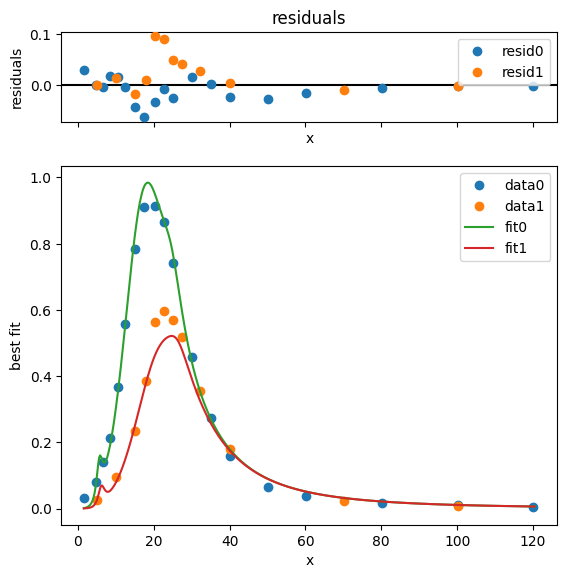

In [15]:
LFG.fit(verbose=True)  # verbose, if True will show fit parameters

# plot fit data & residuals and show initial plot (if True), 
# numpoints=500 to make dense x-array, default None
axes1 = LFG.plot(show_init=False, numpoints=500)  

LFG.report()  # report fit parameters and other attributes

In [16]:
# --- fit data
yfit = LFG.eval()                     # evaluate with x raw data define above
xfit = np.linspace(1, 400, num=6000)   # if more dense data is needed
yfit = LFG.eval(x=xfit)               # dense 

# --- components
# use .eval_components() or .eval_components_per_dataset()
comps = LFG.eval_components()         # evaluate with x raw data define above
comps = LFG.eval_components(x=xfit)   # dense 
# evaluate fit per datasets
# since we are dealing with single dataset
# we expect dict['0', '1'], for n datasets dict['0', '1', '2', ...'n-1']
print('dataset label = ', list(comps.keys()))
# since we are dealin with three components,
# each dataset will have dictionary of 3 component label 'c0', 'c1', 'c2'
print('component label of dataset "0" = ', list(comps['0'].keys()))
print('component label of dataset "1" = ', list(comps['1'].keys()))
# where 'c0', 'c1' and 'c2' are exponential, gaussian 1 and gaussian 2 componets
# i.e. in order of how they are define in `func_lst` above

# --- Also, we can extract initial and best fit as ---
init_fit = LFG.init_fit   # default with x raw data
best_fit = LFG.best_fit   # default with x raw data
# -- or 
init_fit = LFG.eval(params=LFG.initial_params, x=xfit)  # using dense x-array
best_fit = LFG.eval(x=xfit)  # using dense x-array


# --- plot as you desired favorite 

dataset label =  ['0', '1']
component label of dataset "0" =  ['c0', 'c1', 'c2']
component label of dataset "1" =  ['c0', 'c1', 'c2']


The BPP-like behavior is reasonably well reproduced, in particular with a good scaling of the peak position
and its intensity, that diminishes as ∼1/$B_L$, as predicted by the BPP law. A deviation is observed at the
lowest field $B_L$=50 mT,  possibly because of the presence of internal fields with magnitude comparable to
the externally applied one. Hence, based on this argument we safely conclude not to include this field in  
the global fitting procedure displayed and described above. [in Fig. 4(a), Phys. Rev. B 111, 014444 (2025)]

The fitted parameter amplitudes have a missing 10^6 factor because the data was scaled by 10^{-6}. Thus, the fit
value of the amplitudes should be multiplied by 10^6. e.g. c0_amplitude_0 = (2.5045e+08 +/- 6138594.75) x 10^6.



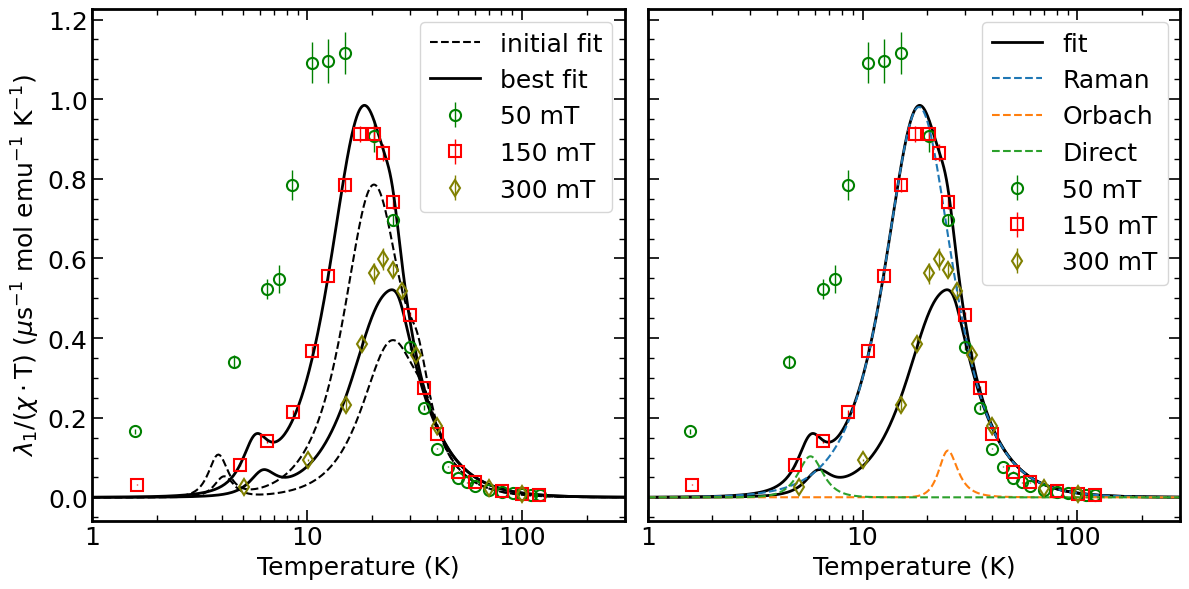

In [17]:
# --- create subplots panel ----
fontsize=18
fig = plt.figure(
    figsize=(12, 6),
    layout='tight' # 'constrained', 'compressed', 'tight', 'none', `.LayoutEngine`, None; default: None
)
axes = fig.subplots(
    nrows=1,
    ncols=2,
    sharex=False,
    sharey=True,
)
for ax in axes.ravel():
    # Major ticks
    ax.tick_params(
        axis='both',
        which='major',
        direction='in',
        length=8,       # major tick length
        width=1.2,      # major tick width
        labelsize=fontsize+0,
        labelcolor='k'
    )

    # Minor ticks
    ax.tick_params(
        axis='both',
        which='minor',
        direction='in',
        length=4,       # minor tick length
        width=1.0       # minor tick width
    )
    ax.tick_params(
        axis='both', which='both',
        top=True, bottom=True, 
        left=True, right=True
        )
    for spine in ax.spines.values():
        spine.set_linewidth(2)   # choose thickness you want

    ax.set_xscale('log')    
    ax.set_xlim([1, 300])
    ax.set_xlabel('Temperature (K)', fontsize=fontsize)

    from matplotlib.ticker import ScalarFormatter
    # ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='x')  # Disable scientific notation

    ax.minorticks_on()
ylabel=r'$\lambda_1/(\chi \cdot \mathrm{T})\ (\mu \mathrm{s}^{-1}\ \mathrm{mol \ emu}^{-1} \ \mathrm{K}^{-1})$'
axes[0].set_ylabel(ylabel, fontsize=fontsize)


field_lst = [500, 1500, 3000]  # in Gausss
color_lst = ['green', 'red', 'olive']
marker_lst = ['o', 's', 'd']

# plt.plot(x, )
for ax in axes.ravel():
    for i in range(1, data_xy_.shape[1]):
        fmt='o'  
        clr=color_lst[i-1]
        fmt=marker_lst[i-1]
        ax.errorbar(
            xdat, 
            data_xy_[:, i],  
            yerr=data_xy_err_[:, i-1], 
            fmt=fmt,
            color=clr, 
            ms=8,
            mew=1.5,
            mfc='white',
            mec=clr,
            capsize=0,
            capthick=0,
            elinewidth=1.0,
            fillstyle='none',
            label=f'{field_lst[i-1]*0.1:.0f} mT'
            ) 



# axes[0].plot(xfit, init_fit, 'k--', label='initial fit')
# axes[0].plot(xfit, best_fit, 'k-',  lw=2, label='best fit')
axes[0].plot(xfit, init_fit[:, 0], 'k--', label='initial fit')
axes[0].plot(xfit, init_fit[:, 1], 'k--', label='_initial fit_')  # no label
axes[0].plot(xfit, best_fit[:, 0], 'k-', lw=2, label='best fit')
axes[0].plot(xfit, best_fit[:, 1], 'k-', lw=2, label='_best fit_')  # no label
#
axes[1].plot(xfit, best_fit[:, 0], 'k-', lw=2, label='fit')
axes[1].plot(xfit, best_fit[:, 1], 'k-', lw=2, label='_fit_')  # no label

axes[1].plot(xfit, comps['0']['c0'], '--', label='Raman')
axes[1].plot(xfit, comps['0']['c1'], '--', label='Orbach')
axes[1].plot(xfit, comps['0']['c2'], '--', label='Direct')


prop={'size': fontsize, 'weight':'normal'}
for ax in axes.ravel():
    ax.legend(frameon=True, prop=prop)


"""NOTE 1:
note = (
    f'The BPP-like behavior is reasonably well reproduced, in particular with a good scaling of the peak position\n'
    f'and its intensity, that diminishes as ∼1/$B_L$, as predicted by the BPP law. A deviation is observed at the\n'   
    f'lowest field $B_L$=50 mT,  possibly because of the presence of internal fields with magnitude comparable to\n' 
    f'the externally applied one. Hence, based on this argument we safely conclude not to include this field in  \n'
    f'the global fitting procedure displayed and described above. [in Fig. 4(a), Phys. Rev. B 111, 014444 (2025)]'
)
   NOTE 2:
note = (
    "The fitted parameter amplitudes have a missing 10^6 factor because the data was scaled by 10^{-6}. Thus, the fit\n"
    "value of the amplitudes should be multiplied by 10^6. e.g. c0_amplitude_0 = (2.5045e+08 +/- 6138594.75) x 10^6.\n"
)
"""
note = (
    f'The BPP-like behavior is reasonably well reproduced, in particular with a good scaling of the peak position\n'
    f'and its intensity, that diminishes as ∼1/$B_L$, as predicted by the BPP law. A deviation is observed at the\n'   
    f'lowest field $B_L$=50 mT,  possibly because of the presence of internal fields with magnitude comparable to\n' 
    f'the externally applied one. Hence, based on this argument we safely conclude not to include this field in  \n'
    f'the global fitting procedure displayed and described above. [in Fig. 4(a), Phys. Rev. B 111, 014444 (2025)]'
)
print(note)
print()
note = (
    "The fitted parameter amplitudes have a missing 10^6 factor because the data was scaled by 10^{-6}. Thus, the fit\n"
    "value of the amplitudes should be multiplied by 10^6. e.g. c0_amplitude_0 = (2.5045e+08 +/- 6138594.75) x 10^6.\n"
)
print(note)

In [18]:
fields = [1500, 3000]  # in Gauss
nc = 3 # number of components
nd = 2 # number of datasets
for i in range(nc):
    for j in range(nd):
        value  = 2.0*np.pi*GAMMA_MU_UNITS_PER_SEC_PER_GAUSS*fields[j]   # Hz or s^-1
        val = (f'c{i}_omega_{j}', value, False, 0, np.inf, None, None)
        print(val)

('c0_omega_0', 127742325.52903542, False, 0, inf, None, None)
('c0_omega_1', 255484651.05807084, False, 0, inf, None, None)
('c1_omega_0', 127742325.52903542, False, 0, inf, None, None)
('c1_omega_1', 255484651.05807084, False, 0, inf, None, None)
('c2_omega_0', 127742325.52903542, False, 0, inf, None, None)
('c2_omega_1', 255484651.05807084, False, 0, inf, None, None)
